# <center>Real NVP [1]</center>

In [9]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

import torchvision

import matplotlib.pyplot as plt
import numpy as np

import sklearn.datasets as datasets

from NF_base import *

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [11]:
class shifting(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = F.leaky_relu(layer(x),0.2)
        return x

class scaling(nn.Module):
    def __init__(self, d_in, nh, d_out, n_layers):
        super().__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(d_in,nh))
        for i in range(n_layers):
            self.layers.append(nn.Linear(nh,nh))
        self.layers.append(nn.Linear(nh,d_out))

    def forward(self, x):
        for layer in self.layers:
            x = torch.tanh(layer(x))
        return x

**Affine coupling layer:** Let $d=\frac{D}{2}$ (we could use an other d),
\begin{equation*}
    \begin{cases}
        z_{1:d} = x_{1:d} \\
        z_{d+1:D} = \exp(s(x_{1:d}))\odot x_{d+1:D}+m(x_{1:d})
    \end{cases}
\end{equation*}

with $m$ a neural network.

For inverting, we got:
\begin{equation*}
    \begin{cases}
        x_{1:d} = z_{1:d} \\
        x_{d+1:D} = \exp(-s(z_{1:d}))\odot (z_{d+1:D}-m(z_{1:d}))
    \end{cases}
\end{equation*}

And $\det J_T(x) = \exp{\sum_j s(x_{1:d})_j}$.

**Batch Norm Layer**: Let $m$ be the mean and $v$ be the variance (of a batch in training time, and of the whole training set in testing time), then a batch norm is:
\begin{equation*}
    x = (z-\beta)\odot e^{-\gamma}\odot (v+\epsilon)^{\frac12}+m
\end{equation*}
with $\gamma$ and $\beta$ some learnable parameters and $\epsilon$ a constant ensuring numerical stability. The invert is:
\begin{equation*}
    z = (x-m)\odot (v+\epsilon)^{-\frac12}\odot e^\gamma +\beta
\end{equation*}
Note that we could put $\gamma$ instead of $e^\gamma$. Then, we have: $\det J_T(x) = e^{\sum_j \gamma_j-\frac12\log(v_j+\epsilon)}$.

A Real NVP is composed of affine coupling layers and batch norm layers. To permute indices, we can just permute even and odd indices (or first and last part of vectors) as it is done here. We could also add permutation or reverse layers.

Possible improvement: Masked convolution: Partitioning is done by using a binary mask $b$:
\begin{equation*}
    y = b\odot x+(1-b)\odot(x\odot\exp(s(b\odot x))+t(b\odot x))
\end{equation*}

## Moons

In [ ]:
def train_moons(model, n_epochs=10001):
    d = 2
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    train_loss = []

    for i in range(n_epochs):
        x, y = datasets.make_moons(128, noise=.1)
        x = torch.tensor(x, dtype=torch.float32).to(device)

        model.train()

        z, log_det = model(x)
        l = loss(z[-1],log_det)

        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_loss.append(l.item())
        
        if i%100==0:
            print(i,train_loss[-1])

        if (i + 1) % 500 == 0:
            model.eval()

            xline = torch.linspace(-1.5, 2.5)
            yline = torch.linspace(-.75, 1.25)
            xgrid, ygrid = torch.meshgrid(xline, yline)
            xyinput = torch.cat([xgrid.reshape(-1, 1), ygrid.reshape(-1, 1)], dim=1)

            with torch.no_grad():
                xy, log_s = model(xyinput.to(device))
                zz = (log_likelihood(xy[-1],log_s)).exp().cpu()
                zgrid = zz.reshape(100,100)


                z = base_distr.sample((100,))
                xs, _ = model.backward(z)
                x = xs[-1].detach()
                x = x.cpu().numpy()
                z = z.cpu().numpy()

            plt.contourf(xgrid.numpy(), ygrid.numpy(), zgrid.numpy())
            plt.colorbar()
            plt.scatter(x[:,0],x[:,1],c="red")
            plt.scatter(z[:,0],z[:,1],c="green")
            plt.xlim(-1.5,2.5)
            plt.ylim(-0.75,1.25)
            plt.title('iteration {}'.format(i + 1))
            plt.show()
            
    return train_loss

In [ ]:
def loss(h,log_det,d=2):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h).mean()
    return -(prior+log_det.mean())

def log_likelihood(h,log_det,d=2):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h)
    return prior+log_det

In [ ]:
d = 2

shiftings = [shifting(d//2,64,d//2,3) for k in range(5)]
scalings = [shifting(d//2,64,d//2,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  126730


0 2.551866292953491
100 1.9283897876739502
200 1.7539875507354736
300 1.7243473529815674
400 1.5786811113357544


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Not providing a value for linspace's steps is deprecated and will throw a runtime error in a future release. This warning will appear only once per process. (Triggered internally at  /pytorch/aten/src/ATen/native/RangeFactories.cpp:23.)


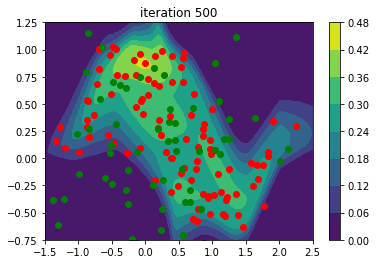

500 1.5239461660385132
600 1.4334197044372559
700 1.421696662902832
800 1.3784844875335693
900 1.431424856185913


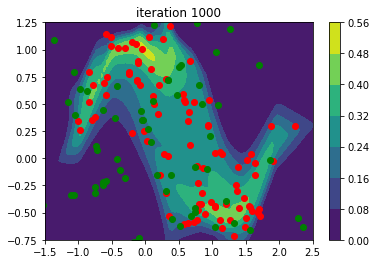

1000 1.3509421348571777
1100 1.3870773315429688
1200 1.2699031829833984
1300 1.337554693222046
1400 1.3705899715423584


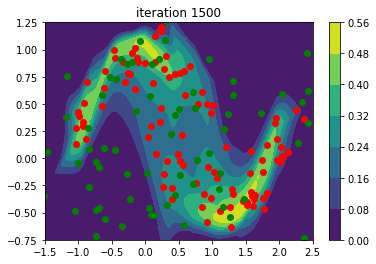

1500 1.2475749254226685
1600 1.2870397567749023
1700 1.3255712985992432
1800 1.3631527423858643
1900 1.258801817893982


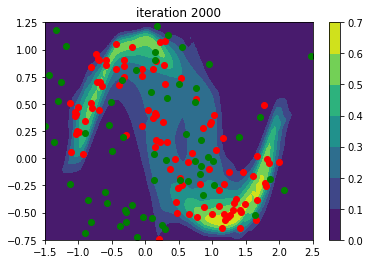

2000 1.563424825668335
2100 1.255009651184082
2200 1.3781640529632568
2300 1.2938915491104126
2400 1.278718113899231


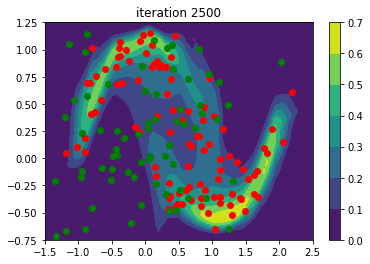

2500 1.2934187650680542
2600 1.2934423685073853
2700 1.2321805953979492
2800 1.2969799041748047
2900 1.1528886556625366


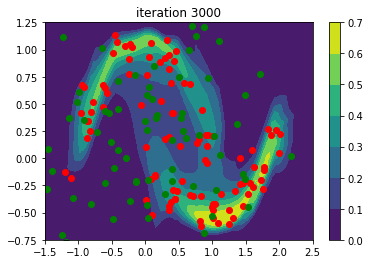

3000 1.282052993774414
3100 1.1601669788360596
3200 1.355722427368164
3300 1.1751054525375366
3400 1.2834827899932861


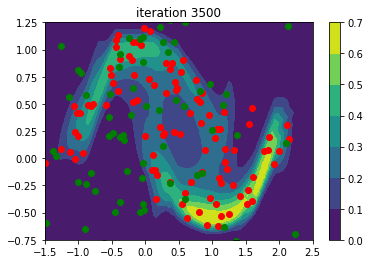

3500 1.2328498363494873
3600 1.2159793376922607
3700 1.1430425643920898
3800 1.2752747535705566
3900 1.0947035551071167


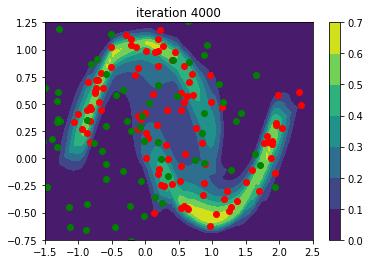

4000 1.231730580329895
4100 1.1757652759552002
4200 1.1533010005950928
4300 1.1376683712005615
4400 1.082531452178955


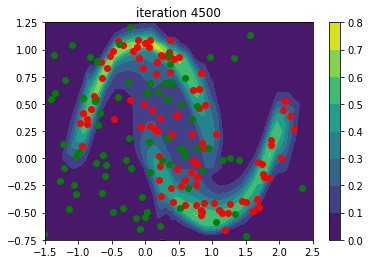

4500 1.113309383392334
4600 1.0912597179412842
4700 1.040717601776123
4800 1.1759817600250244
4900 1.2244619131088257


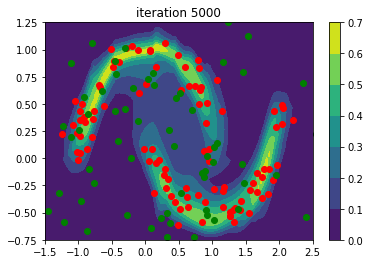

5000 1.0947160720825195
5100 1.2016454935073853
5200 1.1053229570388794
5300 1.165551781654358
5400 1.120832085609436


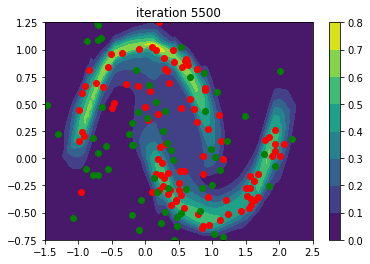

5500 1.186314582824707
5600 1.1583929061889648
5700 1.1014726161956787
5800 1.1042441129684448
5900 1.1454795598983765


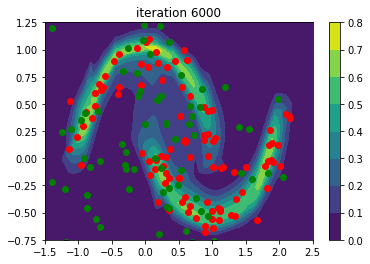

6000 1.074786901473999
6100 1.1624438762664795
6200 0.9875369071960449
6300 1.120473027229309
6400 1.1086483001708984


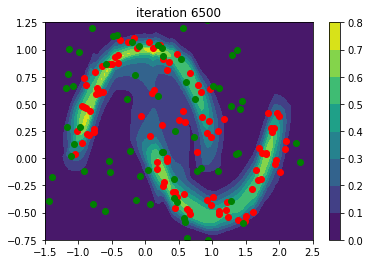

6500 1.0639493465423584
6600 1.1464869976043701
6700 1.1421988010406494
6800 1.1116794347763062
6900 1.1136022806167603


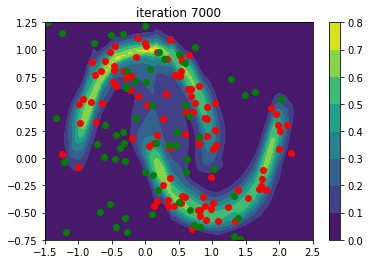

7000 1.057849407196045
7100 1.0512043237686157
7200 1.144973635673523
7300 1.164720058441162
7400 1.0723862648010254


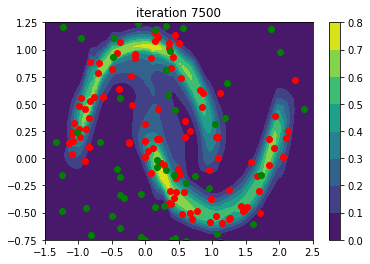

7500 1.1031713485717773
7600 1.0390011072158813
7700 1.0752248764038086
7800 1.0028014183044434
7900 1.2503259181976318


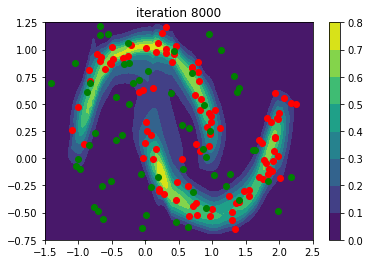

8000 1.1515297889709473
8100 1.0923256874084473
8200 1.038209319114685
8300 1.1927602291107178
8400 1.239181399345398


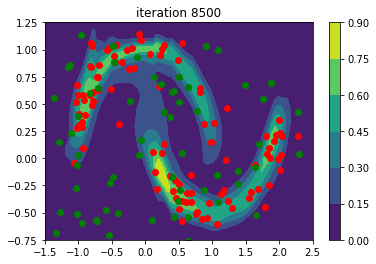

8500 1.093707799911499
8600 1.130111813545227
8700 1.0982166528701782
8800 1.0013294219970703
8900 1.0021015405654907


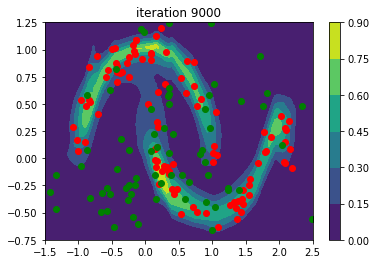

9000 1.312316656112671
9100 1.0775082111358643
9200 1.146301507949829
9300 1.1127197742462158
9400 0.9559721946716309


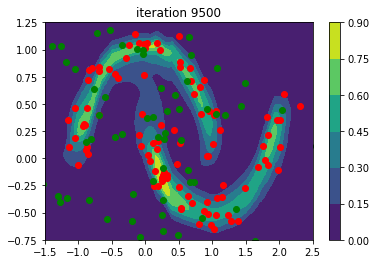

9500 1.220542311668396
9600 1.2882620096206665
9700 1.155980110168457
9800 1.1912281513214111
9900 0.9895615577697754


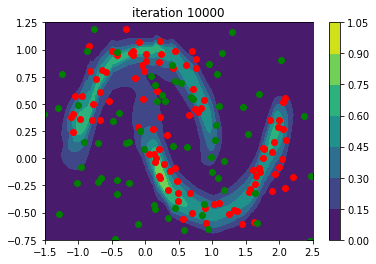

10000 1.014147400856018


In [ ]:
train_loss = train_moons(model)

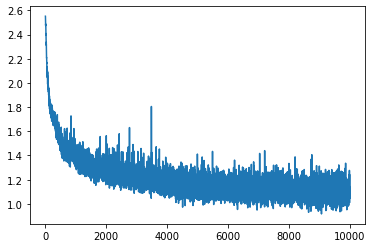

In [ ]:
plt.plot(train_loss)
plt.show()

In [ ]:
d = 2

shiftings = [shifting(d//2,64,d//2,3) for k in range(5)]
scalings = [shifting(d//2,64,d//2,3) for k in range(5)]

flows = []
for i in range(5):
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))
    flows.append(BatchNorm(d))

model = NormalizingFlows(flows).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  126750


0 7.372225284576416
100 6.931722640991211
200 6.578518867492676
300 6.353811264038086
400 6.135889053344727


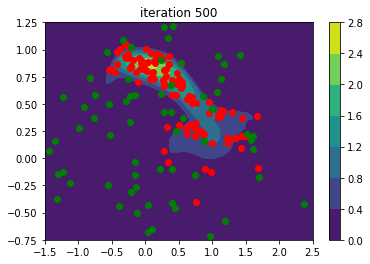

500 6.065164089202881
600 5.906702041625977
700 5.760921955108643
800 5.710154056549072
900 5.433095455169678


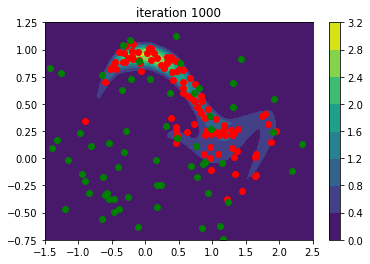

1000 5.290045261383057
1100 5.298625469207764
1200 5.0462846755981445
1300 5.065862655639648
1400 4.862691879272461


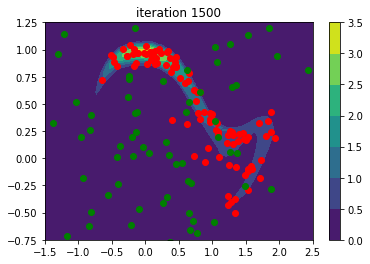

1500 4.71272087097168
1600 4.693563461303711
1700 4.562131404876709
1800 4.466270446777344
1900 4.4027018547058105


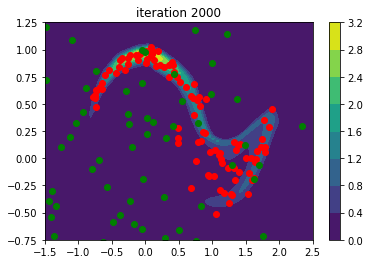

2000 4.331376552581787
2100 4.26168155670166
2200 4.244940757751465
2300 4.012547492980957
2400 3.8441598415374756


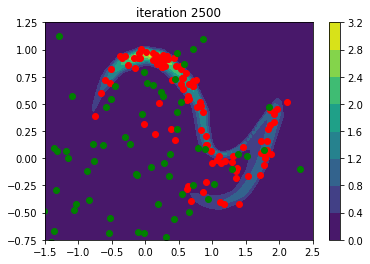

2500 3.849727153778076
2600 3.8369624614715576
2700 3.7915258407592773
2800 3.7185182571411133
2900 3.690703868865967


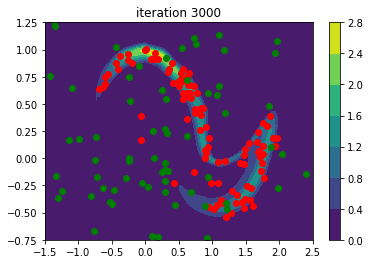

3000 3.493149518966675
3100 3.3878440856933594
3200 3.388478994369507
3300 3.2821121215820312
3400 3.426643133163452


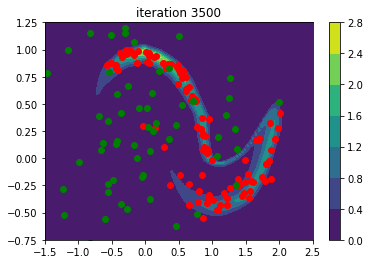

3500 3.0436623096466064
3600 3.0242862701416016
3700 2.972588539123535
3800 3.0222718715667725
3900 3.0233347415924072


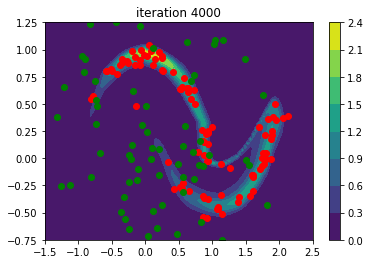

4000 2.9058685302734375
4100 2.92505145072937
4200 2.8212575912475586
4300 2.7246508598327637
4400 2.6673808097839355


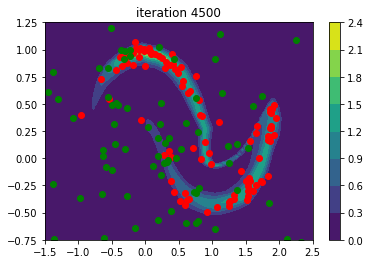

4500 2.593451976776123
4600 2.528390407562256
4700 2.4590845108032227
4800 2.409788131713867
4900 2.512279987335205


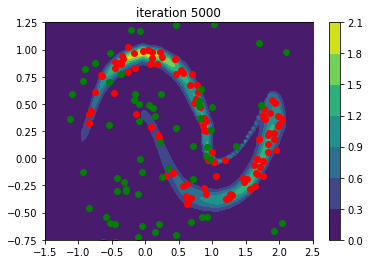

5000 2.3397216796875
5100 2.2876405715942383
5200 2.3188998699188232
5300 2.3528614044189453
5400 2.1295573711395264


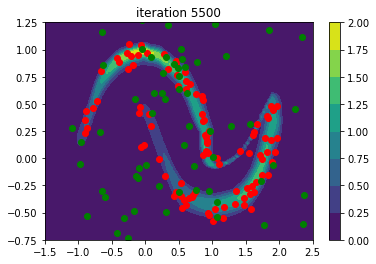

5500 2.136242389678955
5600 2.1643567085266113
5700 2.1977758407592773
5800 2.2271580696105957
5900 2.0546278953552246


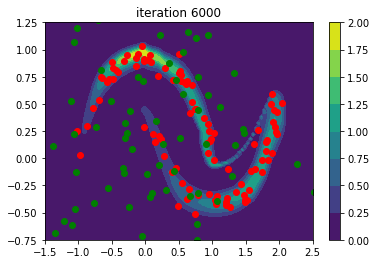

6000 2.0242843627929688
6100 1.9038934707641602
6200 1.9179859161376953
6300 1.8606598377227783
6400 1.8706226348876953


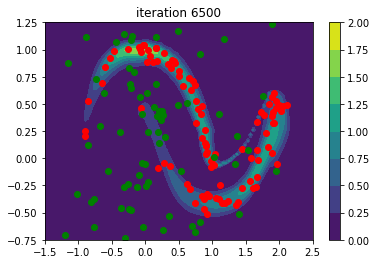

6500 1.7050752639770508
6600 1.7821390628814697
6700 1.7813456058502197
6800 1.7409534454345703
6900 1.8361189365386963


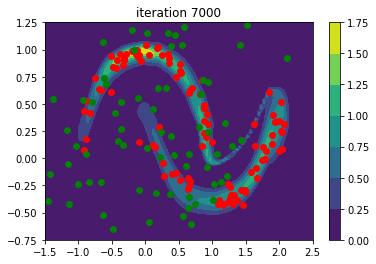

7000 1.845766544342041
7100 1.8462064266204834
7200 1.6904997825622559
7300 1.522115707397461
7400 1.5434722900390625


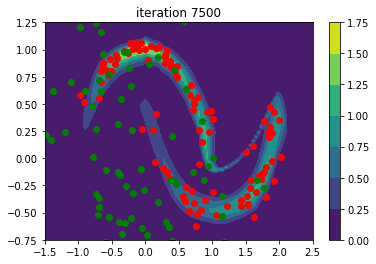

7500 1.7217657566070557
7600 1.647280216217041
7700 1.448319911956787
7800 1.522629976272583
7900 1.5289270877838135


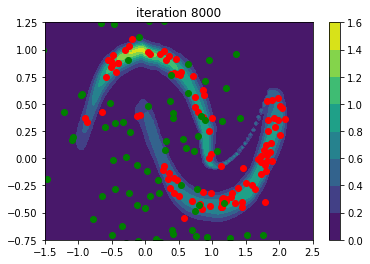

8000 1.5149853229522705
8100 1.4022488594055176
8200 1.4912519454956055
8300 1.3341093063354492
8400 1.3586761951446533


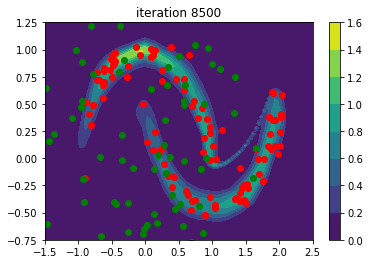

8500 1.3277735710144043
8600 1.4847443103790283
8700 1.449859380722046
8800 1.3018064498901367
8900 1.4271268844604492


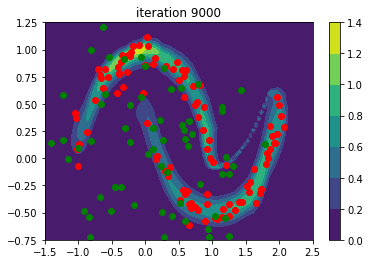

9000 1.2767159938812256
9100 1.3624505996704102
9200 1.2340927124023438
9300 1.3320510387420654
9400 1.2224714756011963


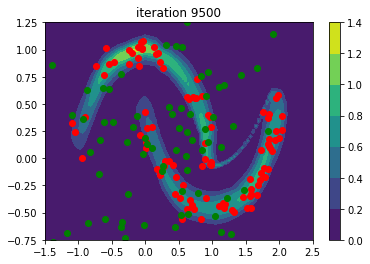

9500 1.2661404609680176
9600 1.2479801177978516
9700 1.1739509105682373
9800 1.2056560516357422
9900 1.211552381515503


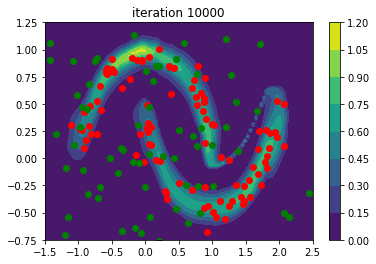

10000 1.2260901927947998


In [ ]:
train_loss = train_moons(model)

## MNIST

In [12]:
def uniform_quantization(img):
    return (img*255+torch.rand(img.size()))/256

def rescale_logit(img,lambd=1e-6):
    ## logit space
    return torch.logit(lambd+(1-2*lambd)*img)

In [13]:
transform = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                uniform_quantization,
                rescale_logit
                # torchvision.transforms.Normalize((0.5,), (0.5,))
    ])

train_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=True, transform=transform, download=True
)

test_dataset = torchvision.datasets.MNIST(
    root="~/torch_datasets", train=False, transform=transform, download=True
)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True, num_workers=4, pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=32, shuffle=False, num_workers=4
)

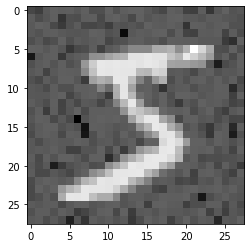

In [14]:
plt.imshow(train_dataset[0][0].reshape(28,28),"gray")
plt.show()

In [15]:
def loss(h,log_det,d=784):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h).mean()
    return -(prior+log_det.mean())

In [16]:
def log_likelihood(h,log_det,d=784):
    base_distr = torch.distributions.multivariate_normal.MultivariateNormal(
        torch.zeros(d,device=device),torch.eye(d,device=device))

    prior = base_distr.log_prob(h)
    return prior+log_det

In [17]:
def val():
    d = 28*28
    torch.manual_seed(42)
    r,c = 5,5
    z_random = torch.randn(r,c,d,device=device)
    model.eval()
    zs,log_det = model.backward(z_random.reshape(-1,28*28))
    gen_imgs = zs[-1].view(-1,28,28)

    cpt = 0
    fig,ax = plt.subplots(r,c)
    for i in range(r):
        for j in range(c):
            ax[i,j].imshow(gen_imgs.detach().cpu()[cpt],"gray")
            cpt += 1
    plt.show()

In [19]:
d = 784

## Add batch normalization?
shiftings = [shifting(d//2,1024,d//2,1) for k in range(5)]
scalings = [scaling(d//2,1024,d//2,1) for k in range(5)]

flows = []
for i in range(5):
    flows.append(AffineCoupling(scalings[i],shiftings[i],d))
    flows.append(Reverse(d))
    flows.append(BatchNorm(d))
    
model = NormalizingFlows(flows).to(device)

In [20]:
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print("number of params: ", sum(p.numel() for p in model.parameters()))

number of params:  18546160


0 3450.6026785714284


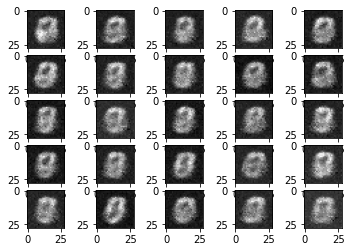

1 3104.6925499108806
2 2868.9698098514127
3 2670.248441456223
4 2496.45841853095
5 2342.318525952825
6 2205.1824318696695
7 2081.797505392957
8 1971.4017633303904
9 1872.1541206668944
10 1783.2155748704859
11 1703.4790681948793
12 1632.2315304233575
13 1568.786696574327
14 1512.1459601754063
15 1462.5960175406449
16 1418.760185192897
17 1380.9405590455924
18 1347.7599842583954
19 1320.1821156320796
20 1296.2730525490572
21 1277.1514348597416
22 1260.9844122197328
23 1248.2552789553904
24 1238.3350653089185
25 1230.889887372568
26 1225.0512461062433
27 1221.2402614438965
28 1218.2247824597714
29 1215.9133043106176
30 1214.376861507196
31 1212.6522385977478
32 1211.2208871414412
33 1210.0056862902286
34 1208.874072369736
35 1207.7682111207357
36 1206.646737104794
37 1205.3611641499533
38 1204.3744948006897
39 1203.0097593783316
40 1202.4274907549307
41 1201.1480450009994
42 1200.4042919297208
43 1199.3098152339585
44 1197.8718862960588
45 1197.4330945370803
46 1196.8713423153486
47 1195.

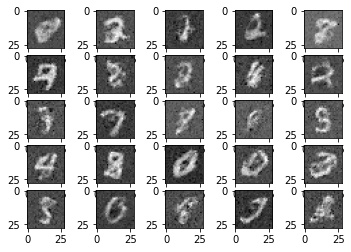

51 1191.5316552526153
52 1190.8012898329225
53 1190.098894131463
54 1189.5081956289978
55 1188.5589336728744
56 1187.9929881146722
57 1186.9687984116804
58 1186.3158612281784
59 1185.442359908049
60 1184.7668204561733
61 1184.013201292644
62 1183.3951944379664
63 1182.754513998784
64 1181.76446910606
65 1181.2965827079724
66 1180.5656134436633
67 1179.9113248975546
68 1179.085749579391
69 1178.8069360403617
70 1177.6984241217185
71 1177.4680956614804
72 1176.8050708892756
73 1176.3083339927039
74 1175.5416949501932
75 1175.1721961828691
76 1174.2779556632297
77 1173.9576163546108
78 1173.3798562641591
79 1172.7726915436767
80 1172.5034622159849
81 1171.6517104939865
82 1170.979446638876
83 1170.6022308935235
84 1170.1722058131497
85 1169.7469198719016
86 1169.297624600213
87 1168.5690873721514
88 1168.2981438545276
89 1167.517423519956
90 1167.395904475946
91 1166.8352766545343
92 1166.537360803405
93 1166.0052883253932
94 1165.0726128356544
95 1165.2429386618803
96 1165.0762169030684


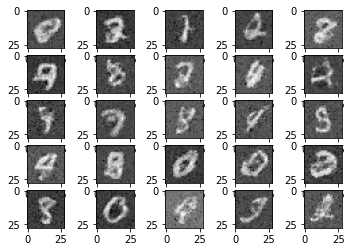

In [21]:
num_epochs = 101

train_losses = []
test_losses = []

for epoch in range(num_epochs):
    model.train()

    train_batch = []

    for n_batch, (data,_) in enumerate(train_loader):
        data = data.to(device)
        data = data.view(-1,28*28)
        z, log_det = model(data)

        l = loss(z[-1], log_det)
        l.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_batch.append(l.item())


    print(epoch, np.mean(train_batch))
    train_losses.append(np.mean(train_batch))

    if epoch % 50 == 0:
        val()


In [25]:
test_batch = []

model.eval()

for n_batch, (data,_) in enumerate(test_loader):
    data = data.to(device)
    data = data.view(-1,28*28)
    z, log_det = model(data)

    l = log_likelihood(z[-1], log_det)

    test_batch.append(l.mean().item())


In [28]:
# Compute the bits per dim (but irrelevant for binary data)
log_likelihood = np.mean(test_batch)
bpd = log_likelihood / (np.prod(784) * np.log(2.))
print(bpd)

-2.2123762962266316


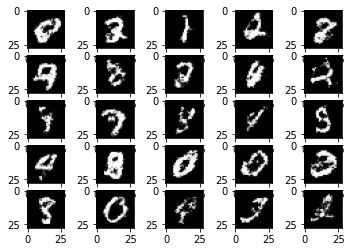

In [23]:
d = 28*28
torch.manual_seed(42)
r,c = 5,5
z_random = torch.randn(r,c,d,device=device)
model.eval()
zs,log_det = model.backward(z_random.reshape(-1,28*28))
gen_imgs = zs[-1].view(-1,28,28)
gen_imgs = gen_imgs.detach().cpu()
lambd = 1e-6
gen_imgs = (torch.sigmoid(gen_imgs)-lambd)/(1-2*lambd)

cpt = 0
fig,ax = plt.subplots(r,c)
for i in range(r):
    for j in range(c):
        ax[i,j].imshow(gen_imgs[cpt],"gray")
        cpt += 1
plt.show()

## References

<a id="reference1"></a>

[1] Dinh, L., Sohl-Dickstein, J., & Bengio, S. Density estimation using Real NVP. arXiv preprint arXiv:1605.08803. (2016). [link](https://arxiv.org/abs/1605.08803)